<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from google.colab import drive
from keras import backend as K

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json')

In [ ]:
df[df['dataset']=='refuge'].groupby(['tag']).size()

tag
Glaucoma     40
Normal      360
dtype: int64

In [3]:
def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = round(x - 0.5*s)
  x1 = round(x + 0.5*s)
  y0 = round(y - 0.5*s)
  y1 = round(y + 0.5*s)
  dx = (x1 - x0) - s
  dy = (y1 - y0) - s
  # penanganan kasus out of image
  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = 0
    x1 -= dx
  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = w-1
    x0 += dx
  else:
    x0 += dx

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = 0
    y1 -= dy
  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = (h-1)
    y0 += dy
  else:
    y0 += dy

  return y0, y1, x0, x1

In [4]:
# Fungsi untuk mengekstrak ROI
# input : list centroid, panjang sisi ROI (s), dan image 
# output : ROI image

def ekstrakROI(centroid, s, img):
  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1, x0:x1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fscore(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [7]:
def k_fold_cross_data(X, y, k=5, test_size=0.2, random_state=4):
  X_dr_gl = np.array(X[0])
  X_dr_n = np.array(X[1])
  X_re_gl = np.array(X[2])
  X_re_n = np.array(X[3])
  y_dr_gl = np.array(y[0])
  y_dr_n = np.array(y[1])
  y_re_gl = np.array(y[2])
  y_re_n = np.array(y[3])
  random.Random(random_state).shuffle(X_dr_gl)
  random.Random(random_state).shuffle(X_dr_n)
  random.Random(random_state).shuffle(X_re_gl)
  random.Random(random_state).shuffle(X_re_n)
  random.Random(random_state).shuffle(y_dr_gl)
  random.Random(random_state).shuffle(y_dr_n)
  random.Random(random_state).shuffle(y_re_gl)
  random.Random(random_state).shuffle(y_re_n)
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  dataset = []
  for i in tqdm_notebook(range(k)):
    # index of dataset-label for train data
    tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
    tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
    tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
    tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

    # index of dataset-label for test data
    te_dr_gl = list(range(dr_gl[i]), dr_gl[i+1]) 
    te_dr_n = list(range(dr_n[i]), dr_n[i+1])
    te_re_gl = list(range(re_gl[i]), re_gl[i+1])
    te_re_n = list(range(re_n[i]), re_n[i+1])

    X_train = np.concatenate((X_dr_gl[tr_dr_gl], X_dr_n[tr_dr_n], 
                             X_re_gl[tr_re_gl], X_re_n[tr_re_n]))
    X_test = np.concatenate((X_dr_gl[te_dr_gl], X_dr_n[te_dr_n], 
                             X_re_gl[te_re_gl], X_re_n[te_re_n]))
    y_train = np.concatenate((y_dr_gl[tr_dr_gl], y_dr_n[tr_dr_n], 
                             y_re_gl[tr_re_gl], y_re_n[tr_re_n]))
    y_test = np.concatenate((y_dr_gl[te_dr_gl], y_dr_n[te_dr_n], 
                             y_re_gl[te_re_gl], y_re_n[te_re_n]))
    dataset.append([X_train, X_test, y_train, y_test])
  
  return dataset

In [8]:
def k_fold_cross_ix(df, k=5, test_size=0.2, random_state=4):
  random.Random(random_state).shuffle(X_dr_gl)
  random.Random(random_state).shuffle(X_dr_n)
  random.Random(random_state).shuffle(X_re_gl)
  random.Random(random_state).shuffle(X_re_n)
  random.Random(random_state).shuffle(y_dr_gl)
  random.Random(random_state).shuffle(y_dr_n)
  random.Random(random_state).shuffle(y_re_gl)
  random.Random(random_state).shuffle(y_re_n)
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  dataset = []
  for i in tqdm_notebook(range(k)):
    # index of dataset-label for train data
    tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
    tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
    tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
    tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

    # index of dataset-label for test data
    te_dr_gl = list(range(dr_gl[i]), dr_gl[i+1]) 
    te_dr_n = list(range(dr_n[i]), dr_n[i+1])
    te_re_gl = list(range(re_gl[i]), re_gl[i+1])
    te_re_n = list(range(re_n[i]), re_n[i+1])

    X_train = np.concatenate((X_dr_gl[tr_dr_gl], X_dr_n[tr_dr_n], 
                             X_re_gl[tr_re_gl], X_re_n[tr_re_n]))
    X_test = np.concatenate((X_dr_gl[te_dr_gl], X_dr_n[te_dr_n], 
                             X_re_gl[te_re_gl], X_re_n[te_re_n]))
    y_train = np.concatenate((y_dr_gl[tr_dr_gl], y_dr_n[tr_dr_n], 
                             y_re_gl[tr_re_gl], y_re_n[tr_re_n]))
    y_test = np.concatenate((y_dr_gl[te_dr_gl], y_dr_n[te_dr_n], 
                             y_re_gl[te_re_gl], y_re_n[te_re_n]))
    dataset.append([X_train, X_test, y_train, y_test])
  
  return df_train, df_test

In [9]:
def show_examples(examples, y_examples):
  plt.figure(figsize=(12, 4))
  plt.grid(False)
  for i, example in enumerate(examples):
    h, w = example.shape[:2]
    mask = np.array(example > 0.5, np.uint8)*255
    gt_mask = np.array(y_examples[i] > 0, np.uint8)*255
    DSC = np.sum(mask[gt_mask==255])*2.0 / (np.sum(mask) + np.sum(gt_mask))
    mask = mask.squeeze()
    gt_mask = gt_mask.squeeze()
    mask_show = np.zeros((h, w, 3), np.uint8)
    gt_mask_show = np.zeros((h, w, 3), np.uint8)

    mask_show[:, :, 0] = mask
    gt_mask_show[:, :, 2] = gt_mask
    
    plt.subplot(1, len(examples), i+1),
    plt.imshow(mask_show,  interpolation='none')
    plt.imshow(gt_mask_show, interpolation='none', alpha=0.35)
    plt.text(20, 40, 'DSC: {:.3f}'.format(DSC), fontsize='small', color ='w')

  plt.show()

In [10]:
def downscale(img):
    size = (256, 256)
    img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)
    return img

def upscale(img):
  size = (550, 550)
  img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)

  return img

In [11]:
def k_fold_crossval(X, y, y_ori, callbacks, tipe, k=5, random_state=4, save=0):
  X_dr_gl = np.array(X[0])
  X_dr_n = np.array(X[1])
  X_re_gl = np.array(X[2])
  X_re_n = np.array(X[3])
  y_dr_gl = np.array(y[0])
  y_dr_n = np.array(y[1])
  y_re_gl = np.array(y[2])
  y_re_n = np.array(y[3])
  y_dr_glo = np.array(y_ori[0])
  y_dr_no = np.array(y_ori[1])
  y_re_glo = np.array(y_ori[2])
  y_re_no = np.array(y_ori[3])
  random.Random(random_state).shuffle(X_dr_gl)
  random.Random(random_state).shuffle(X_dr_n)
  random.Random(random_state).shuffle(X_re_gl)
  random.Random(random_state).shuffle(X_re_n)
  random.Random(random_state).shuffle(y_dr_gl)
  random.Random(random_state).shuffle(y_dr_n)
  random.Random(random_state).shuffle(y_re_gl)
  random.Random(random_state).shuffle(y_re_n)
  random.Random(random_state).shuffle(y_dr_glo)
  random.Random(random_state).shuffle(y_dr_no)
  random.Random(random_state).shuffle(y_re_glo)
  random.Random(random_state).shuffle(y_re_no)
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  input_img = Input((256,256, 1), name='img')
  results = []
  fold = []
  Loss = []
  Accuracy = []
  f1score = []
  models = []
  for i in tqdm_notebook(range(k)):
    # index of dataset-label for train data
    tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
    tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
    tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
    tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

    # index of dataset-label for test data
    te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
    te_dr_n = list(range(dr_n[i], dr_n[i+1]))
    te_re_gl = list(range(re_gl[i], re_gl[i+1]))
    te_re_n = list(range(re_n[i], re_n[i+1]))


    X_train = np.concatenate((X_dr_gl[tr_dr_gl], X_dr_n[tr_dr_n], 
                             X_re_gl[tr_re_gl], X_re_n[tr_re_n]))
    X_test = np.concatenate((X_dr_gl[te_dr_gl], X_dr_n[te_dr_n], 
                             X_re_gl[te_re_gl], X_re_n[te_re_n]))
    y_train = np.concatenate((y_dr_gl[tr_dr_gl], y_dr_n[tr_dr_n], 
                             y_re_gl[tr_re_gl], y_re_n[tr_re_n]))
    y_test = np.concatenate((y_dr_gl[te_dr_gl], y_dr_n[te_dr_n], 
                             y_re_gl[te_re_gl], y_re_n[te_re_n]))
    y_test_ori = np.concatenate((y_dr_glo[te_dr_gl], y_dr_no[te_dr_n], 
                             y_re_glo[te_re_gl], y_re_no[te_re_n]))

    random.Random(random_state).shuffle(X_train)
    random.Random(random_state).shuffle(X_test)
    random.Random(random_state).shuffle(y_train)
    random.Random(random_state).shuffle(y_test)
    random.Random(random_state).shuffle(y_test_ori)

    print('Evaluate fold ', i+1)
    model= get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy",fscore])
    result = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_test, y_test), verbose=0)
    
    results.append(result)
    model_layer = model.layers[-1]
    lu = Lambda(upscale, name="lambda_upscale")(model_layer.output)
    model_upscale = Model(model.input, lu, name="upscale_model")
    model_upscale.compile(loss="binary_crossentropy", metrics=["accuracy",fscore])
    models.append(model_upscale)

    los = result.history['val_loss'][-1]
    acc = result.history['val_accuracy'][-1]
    f1 = result.history['val_fscore'][-1]
    los_550, acc_550, f1_550 = model_upscale.evaluate(X_test, y_test_ori, verbose=0)
    
    y_examples = y_test_ori[:3]
    examples = model_upscale.predict(X_test[:3]) 

    fold.append(i + 1)
    Loss.append(los)
    Accuracy.append(acc)
    f1score.append(f1)
    print('Fold {}\nloss: {:.4f} - acc: {:.3f} - fscore: {:.3f}'.format(i+1, los, acc, f1))
    print('after upscalling\nloss: {:.4f} - acc: {:.3f} - fscore: {:.3f}'.format(los_550, acc_550, f1_550))
    show_examples(examples, y_examples)

  metrics = pd.DataFrame({'Fold': fold, 'Loss':Loss, 'Acc':Accuracy,
                          'Fscore': f1score})
  best_fold = np.argmax(f1score)
  print('Best model is fold-', best_fold+1)
  if save:
    print('Saving best model from fold-', best_fold+1)
    models[best_fold].save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model {} semantic/'.format(tipe))
    print('Save model success!')
  return results, metrics

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
X = []
y_OD_r = []
y_OC_r = []
y_OD = []
y_OC = []

X_dr_gl = []
X_dr_n = []
X_re_gl = []
X_re_n = []
y_dr_gl_OD = []
y_dr_n_OD = []
y_re_gl_OD = []
y_re_n_OD = []
y_dr_gl_OC = []
y_dr_n_OC = []
y_re_gl_OC = []
y_re_n_OC = []

y_dr_glr_OD = []
y_dr_nr_OD = []
y_re_glr_OD = []
y_re_nr_OD = []
y_dr_glr_OC = []
y_dr_nr_OC = []
y_re_glr_OC = []
y_re_nr_OC = []

for i in tqdm_notebook(range(0, len(df))):  
  center = df['disc_center'][i]
  img = cv2.imread(df['path'][i], 1)[:,:,1]
  img = clahe.apply(img)
  gt_OD = cv2.imread(df['path_OD_png'][i], 0)
  gt_OC = cv2.imread(df['path_OC_png'][i], 0)

  img,_ = ekstrakROI(center, 550, img)
  gt_OD,_ = ekstrakROI(center, 550, gt_OD)
  gt_OC,_ = ekstrakROI(center, 550, gt_OC)
  img = (resize(img, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OD_r = (resize(gt_OD, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OC_r = (resize(gt_OC, (256, 256, 1), mode = 'constant', preserve_range = True))/255.0
  gt_OD = gt_OD/255.0
  gt_OC = gt_OC/255.0
  if df['dataset'][i] == 'drishti':
    if df['tag'][i] == 'Glaucoma':
      X_dr_gl.append(img)
      y_dr_gl_OD.append(gt_OD)
      y_dr_gl_OC.append(gt_OC)
      y_dr_glr_OD.append(gt_OD_r)
      y_dr_glr_OC.append(gt_OD_r)
    elif df['tag'][i] == 'Normal':
      X_dr_n.append(img)
      y_dr_n_OD.append(gt_OD)
      y_dr_n_OC.append(gt_OC)
      y_dr_nr_OD.append(gt_OD_r)
      y_dr_nr_OC.append(gt_OD_r)
  elif df['dataset'][i] == 'refuge':
    if df['tag'][i] == 'Glaucoma':
      X_re_gl.append(img)
      y_re_gl_OD.append(gt_OD)
      y_re_gl_OC.append(gt_OC)
      y_re_glr_OD.append(gt_OD_r)
      y_re_glr_OC.append(gt_OD_r)
    elif df['tag'][i] == 'Normal':
      X_re_n.append(img)
      y_re_n_OD.append(gt_OD)
      y_re_n_OC.append(gt_OC)
      y_re_nr_OD.append(gt_OD_r)
      y_re_nr_OC.append(gt_OD_r)

X = [X_dr_gl, X_dr_n, X_re_gl, X_re_n]
y_OD = [y_dr_gl_OD, y_dr_n_OD, y_re_gl_OD, y_re_n_OD]
y_OC = [y_dr_gl_OC, y_dr_n_OC, y_re_gl_OC, y_re_n_OC]
y_OD_r = [y_dr_glr_OD, y_dr_nr_OD, y_re_glr_OD, y_re_nr_OD]
y_OC_r = [y_dr_glr_OC, y_dr_nr_OC, y_re_glr_OC, y_re_nr_OC]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
callbacks_OD = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=0)
    #ModelCheckpoint('model-OD.h5', verbose=0, save_best_only=True, save_weights_only=True)
]
callbacks_OC = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=0)
    #ModelCheckpoint('model-OC.h5', verbose=0, save_best_only=True, save_weights_only=True)
]

In [ ]:
dataset_OD = k_fold_cross_data(X, y_OD, k=5, test_size=0.2, random_state=4)
dataset_OC = k_fold_cross_data(X, y_OC, k=5, test_size=0.2, random_state=4)

In [ ]:
X_train_OD1, X_test_OD1, y_train_OD1, y_test_OD1 = train_test_split(X, y_OD, 
                                                                test_size=0.2, 
                                                                random_state = 5)
X_train_OC1, X_test_OC1, y_train_OC1, y_test_OC1 = train_test_split(X, y_OC, 
                                                                test_size=0.2, 
                                                                random_state = 5)

In [16]:
input_img = Input((256,256, 1), name='img')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluate fold  1
Fold 1
loss: 0.0531 - acc: 0.973 - fscore: 0.967
after upscalling
loss: 0.0525 - acc: 0.983 - fscore: 0.968


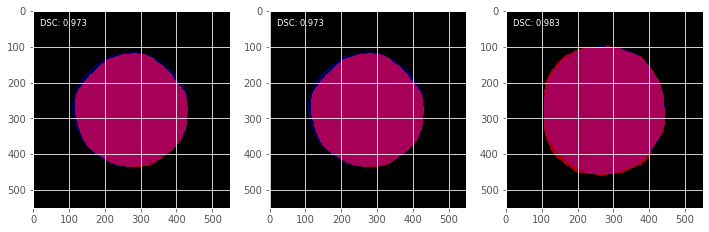

Evaluate fold  2
Fold 2
loss: 0.1060 - acc: 0.963 - fscore: 0.947
after upscalling
loss: 0.1057 - acc: 0.972 - fscore: 0.948


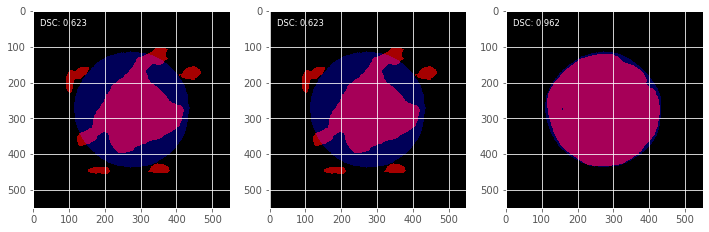

Evaluate fold  3
Fold 3
loss: 0.0878 - acc: 0.966 - fscore: 0.954
after upscalling
loss: 0.0875 - acc: 0.976 - fscore: 0.955


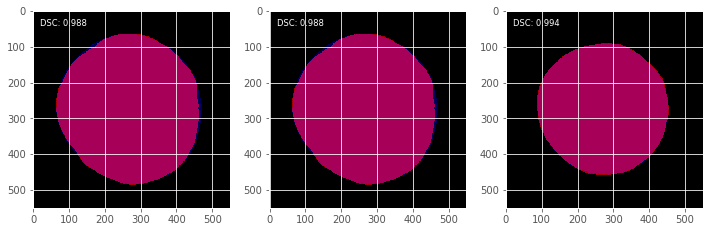

Evaluate fold  4
Fold 4
loss: 0.0879 - acc: 0.961 - fscore: 0.946
after upscalling
loss: 0.0875 - acc: 0.971 - fscore: 0.947


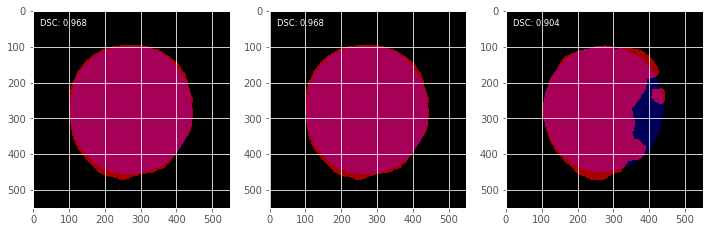

Evaluate fold  5
Fold 5
loss: 0.1508 - acc: 0.953 - fscore: 0.934
after upscalling
loss: 0.1506 - acc: 0.963 - fscore: 0.935


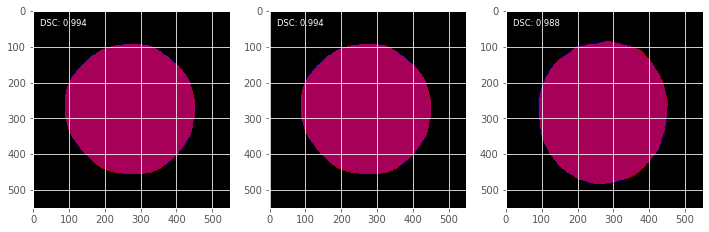


Best model is fold- 1
Saving best model from fold- 1


IndexError: ignored

In [31]:
results_OD, metrics_OD = k_fold_crossval(X, y_OD_r, y_OD, callbacks_OD, 'OD', 
                                         k=5, random_state=4, save=0)

In [ ]:
results_OC, metrics_OC = k_fold_crossval(X, y_OC_r, y_OC, callbacks_OC, 'OC',
                                         k=5, random_state=4, save=0)

In [ ]:
model_OD = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OD.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', fscore])

model_OC = get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True)
model_OC.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy', fscore])

In [ ]:
model_OD.summary()

In [ ]:
results_OD = model_OD.fit(X_train_OD1, y_train_OD1, batch_size=32, epochs=100, callbacks=callbacks_OD,\
                    validation_data=(X_test_OD1, y_test_OD1))

In [ ]:
results_OC = model_OC.fit(X_train_OC, y_train_OC, batch_size=32, epochs=100, callbacks=callbacks_OC,\
                    validation_data=(X_test_OC, y_test_OC))

In [ ]:
metrics_OD = np.array(metrics_OD)
metrics_OC = np.array(metrics_OC)

In [ ]:
avg_loss = np.mean(metrics_OD[:, 0])
avg_acc = np.mean(metrics_OD[:, 1])
avg_fscore = np.mean(metrics_OD[:, 2])
print('avearge loss: {:.2f}'.format(avg_loss))
print('avearge accuracy: {:.2f}'.format(avg_acc))
print('avearge fscore: {:.2f}'.format(avg_fscore))

avearge loss: 0.12
avearge accuracy: 0.95
avearge fscore: 0.93


In [ ]:
avg_loss = np.mean(metrics_OC[:, 0])
avg_acc = np.mean(metrics_OC[:, 1])
avg_fscore = np.mean(metrics_OC[:, 2])
print('avearge loss: {:.2f}'.format(avg_loss))
print('avearge accuracy: {:.2f}'.format(avg_acc))
print('avearge fscore: {:.2f}'.format(avg_fscore))

avearge loss: 0.04
avearge accuracy: 0.98
avearge fscore: 0.95


In [ ]:
def histo(histories):
  for i, histori in enumerate(histories):
    plt.figure(figsize=(20, 5))
    print('Fold-{}'.format(i+1))
    plt.subplot(131), 
    plt.plot(histori.history["accuracy"], label="accuracy")
    plt.plot(histori.history["val_accuracy"], label="val_acc")
    plt.plot(np.argmax(histori.history["val_accuracy"]), np.max(histori.history["val_accuracy"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(132), 
    plt.plot(histori.history["fscore"], label="fscore")
    plt.plot(histori.history["val_fscore"], label="val_fscore")
    plt.plot( np.argmax(histori.history["val_fscore"]), np.max(histori.history["val_fscore"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Fscore")
    plt.legend()
    plt.subplot(133),
    plt.plot(histori.history["loss"], label="loss")
    plt.plot(histori.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(histori.history["val_loss"]), np.min(histori.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.show()

In [ ]:
metrics_OD.describe()

In [ ]:
metrics_OC.describe()

In [ ]:
histo(results_OD)

In [ ]:
histo(results_OC)

In [ ]:
plt.figure(figsize=(14, 7))
plt.title("Learning curve")

plt.subplot(231), 
plt.plot(results_OD.history["accuracy"], label="accuracy")
plt.plot(results_OD.history["val_accuracy"], label="val_acc")
plt.plot(np.argmin(results_OD.history["val_accuracy"]), np.max(results_OD.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(232), 
plt.plot(results_OD.history["f1_m"], label="fscore")
plt.plot(results_OD.history["val_f1_m"], label="val_fscore")
plt.plot( np.argmin(results_OD.history["val_f1_m"]), np.max(results_OD.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Fscore")
plt.legend()
plt.subplot(233),
plt.plot(results_OD.history["loss"], label="loss")
plt.plot(results_OD.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_OD.history["val_loss"]), np.min(results_OD.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

plt.subplot(223), 
plt.plot(results_OC.history["f1_m"], label="f1_m")
plt.plot(results_OC.history["val_f1_m"], label="val_f1_m")
plt.plot( np.argmin(results_OC.history["val_f1_m"]), np.min(results_OC.history["val_f1_m"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Fscore")
plt.legend()
plt.title("Learning curve")
plt.subplot(224),
plt.plot(results_OC.history["loss"], label="loss")
plt.plot(results_OC.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_OC.history["val_loss"]), np.min(results_OC.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()


In [ ]:
model_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')

# Inference

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
model_OD.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.load_model('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_OD.evaluate(X_test_OD, y_test_OD, verbose=1)
model_OC.evaluate(X_test_OC, y_test_OC, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train_OD = model_OD.predict(X_train_OD, verbose=1)
preds_val_OD = model_OD.predict(X_test_OD, verbose=1)
preds_train_OC = model_OC.predict(X_train_OC, verbose=1)
preds_val_OC = model_OC.predict(X_test_OC, verbose=1)

In [ ]:
# Threshold predictions
preds_train_t_OD = (preds_train_OD > 0.5).astype(np.uint8)
preds_val_t_OD = (preds_val_OD > 0.5).astype(np.uint8)
preds_train_t_OC = (preds_train_OC > 0.5).astype(np.uint8)
preds_val_t_OC = (preds_val_OC > 0.5).astype(np.uint8)

In [ ]:
import scipy.ndimage
import cv2
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 5, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

    resample = cv2.resize(binary_preds[ix].squeeze(), (550, 550), interpolation = cv2.INTER_CUBIC)
    ax[4].imshow(resample)
    ax[4].set_title('resampled')
    print(resample.shape)

# Plot image

In [ ]:
# Check if training data looks all right
plot_sample(X_train_OD, y_train_OD, preds_train_OD, preds_train_t_OD, ix=30)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=30)

In [ ]:
plot_sample(X_train_OD, y_train_OD, preds_train_OD, preds_train_t_OD, ix=1)

In [ ]:
plot_sample(X_train_OC, y_train_OC, preds_train_OC, preds_train_t_OC, ix=1)

# Saving model

In [ ]:
model_OD.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OD semantic/')
model_OC.save('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/model OC semantic/')